In [ ]:
import gymnasium as gym
import safety_gymnasium

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback

ENV_ID = "SafetyPointGoal1-v0"     # tâche simple, contrainte de collision

import gymnasium as gym
import safety_gymnasium
from safety_gymnasium.wrappers import SafetyGymnasium2Gymnasium

def make_env():
    safe_env = safety_gymnasium.make("SafetyPointGoal1-v0", render_mode=None)
    env = SafetyGymnasium2Gymnasium(safe_env)   # ⇨ API Gymnasium
    return env
if __name__ == "__main__":
    train_env = make_env()
    eval_env  = make_env()

    model = PPO(
        policy="MlpPolicy",
        env=train_env,
        verbose=1,
        tensorboard_log="./ppo/ppo_tb",
        batch_size=4096,
        n_steps=8192,
    )

    eval_cb = EvalCallback(
        eval_env,
        eval_freq=10_000,
        best_model_save_path="./ppo/ppo_best",
        log_path="./ppo/ppo_eval",
        deterministic=True,
    )

    model.learn(total_timesteps=1_000_000, callback=eval_cb)
    model.save("ppo_safety_point_goal1")

    train_env.close(); eval_env.close()


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_tb/PPO_6
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -0.0361  |
| time/              |          |
|    fps             | 733      |
|    iterations      | 1        |
|    time_elapsed    | 11       |
|    total_timesteps | 8192     |
---------------------------------


/home/chaos/miniconda3/envs/safe_rl/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=-26.77 +/- 2.07
Episode length: 1000.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+03       |
|    mean_reward          | -26.8       |
| time/                   |             |
|    total_timesteps      | 10000       |
| train/                  |             |
|    approx_kl            | 0.004337332 |
|    clip_fraction        | 0.021       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | -9.75       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00613     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00221    |
|    std                  | 0.996       |
|    value_loss           | 0.0478      |
-----------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     |

In [ ]:
import os
os.environ["MUJOCO_GL"] = "egl"           # or osmesa
os.environ["PYOPENGL_PLATFORM"] = "egl"

from stable_baselines3 import PPO
import safety_gymnasium
from safety_gymnasium.wrappers import SafetyGymnasium2Gymnasium
from gymnasium.wrappers import RecordVideo

# --- 1. 3rd‑person env ----------------------------------------------------
base_env = safety_gymnasium.make(
    "SafetyPointGoal1-v0",
    render_mode="rgb_array",
    camera_name="track",          # <‑‑ HERE: 3rd‑person chase camera
)
env = SafetyGymnasium2Gymnasium(base_env)

# --- 2. Record exactly one episode ---------------------------------------
env = RecordVideo(
    env,
    video_folder="/home/chaos/Desktop/Projet_Safe-RL",
    episode_trigger=lambda ep: ep == 0,
    name_prefix="ppo_rollout_3rd",
    disable_logger=True,
)

# --- 3. Load policy & roll ~30 s (900 steps) ------------------------------
model = PPO.load("ppo/ppo_best/best_model")   # best checkpoint

obs, _ = env.reset(seed=0)
for _ in range(900):                      # 30 s @ 30 FPS
    action, _ = model.predict(obs, deterministic=True)
    obs, _, done, truncated, _ = env.step(action)
    if done or truncated:
        break

env.close()
print("✅  saved → /home/chaos/Desktop/Projet_Safe-RL/ppo_rollout_3rd-episode-0.mp4")


/home/chaos/miniconda3/envs/safe_rl/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /home/chaos/Desktop/Projet_Safe-RL folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


✅  saved → /home/chaos/Desktop/Projet_Safe-RL/ppo_rollout_3rd-episode-0.mp4


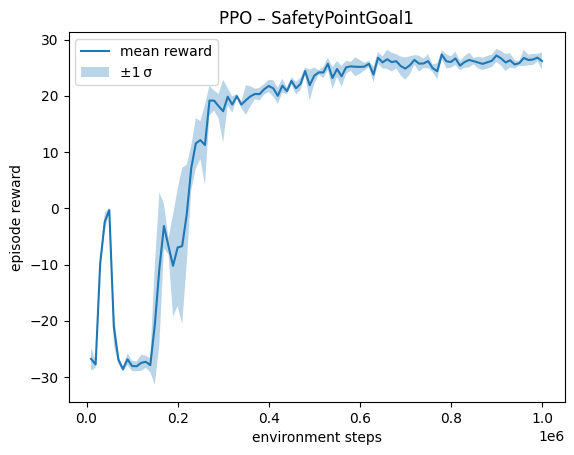

In [7]:
import numpy as np, matplotlib.pyplot as plt

data = np.load("ppo_eval/evaluations.npz")
timesteps      = data["timesteps"]          # shape (k,)
results        = data["results"]            # shape (k, n_eval_episodes)
mean_rewards   = results.mean(axis=1)
std_rewards    = results.std(axis=1)

plt.plot(timesteps, mean_rewards, label="mean reward")
plt.fill_between(
    timesteps,
    mean_rewards - std_rewards,
    mean_rewards + std_rewards,
    alpha=0.3,
    label="±1 σ",
)
plt.xlabel("environment steps")
plt.ylabel("episode reward")
plt.title("PPO – SafetyPointGoal1")
plt.legend()
plt.show()


## omnisafe train --algo CPO --env-id SafetyPointGoal1-v0 --total-steps 1000000 --vector-env-nums 1 --device cuda:0 --log-dir cpo_logs

In [ ]:
import os
import gymnasium as gym
import safety_gymnasium
from safety_gymnasium.wrappers import SafetyGymnasium2Gymnasium
from gymnasium.wrappers import RecordVideo
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# -----------------------------------------------------------------------------
# Environment variables for headless rendering (if applicable)
os.environ["MUJOCO_GL"] = "egl"           # or "osmesa"
os.environ["PYOPENGL_PLATFORM"] = "egl"

# -----------------------------------------------------------------------------
# Define the policy network architecture that matches OmniSafe's checkpoint.
class CPOPolicyNetwork(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int, hidden_sizes=(64, 64)):
        super(CPOPolicyNetwork, self).__init__()
        layers = []
        last_dim = obs_dim
        # Build the network and assign it to self.mean so that the keys match.
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(last_dim, hidden_size))
            layers.append(nn.ReLU())
            last_dim = hidden_size
        layers.append(nn.Linear(last_dim, action_dim))
        self.mean = nn.Sequential(*layers)
        # Create a learnable log_std parameter (one per action dimension)
        self.log_std = nn.Parameter(torch.zeros(action_dim))
        
    def forward(self, x):
        # Return the mean of the policy.
        return self.mean(x)

# -----------------------------------------------------------------------------
# Wrapper to provide a predict() method similar to Stable Baselines3.
class CPOModuleWrapper:
    def __init__(self, model: nn.Module):
        self.model = model
        self.model.eval()

    def predict(self, obs, deterministic=True):
        # Convert observation (NumPy array) to a torch tensor with a batch dimension.
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            # Use the model's forward method to get the mean action.
            action_tensor = self.model(obs_tensor)
        # Remove the batch dimension and convert the result to NumPy.
        action = action_tensor.squeeze(0).cpu().numpy()
        return action, None

# -----------------------------------------------------------------------------
# Function to load the OmniSafe CPO model checkpoint.
def load_cpo_model(checkpoint_path: str, obs_dim: int, action_dim: int) -> CPOModuleWrapper:
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(
            f"Checkpoint file was not found at: {checkpoint_path}. "
            "Please verify the file path and name, or check if the model was saved correctly."
        )
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    
    # If the checkpoint is a dictionary with key "pi", extract the policy state dict.
    if isinstance(checkpoint, dict) and "pi" in checkpoint:
        policy_state_dict = checkpoint["pi"]
    else:
        policy_state_dict = checkpoint

    # Print out the keys of the loaded state dictionary for inspection.
    print("Policy state dict keys:", list(policy_state_dict.keys()))
    
    # Instantiate the model with the new architecture.
    model = CPOPolicyNetwork(obs_dim, action_dim, hidden_sizes=(64, 64))
    
    # Load the state dictionary with strict=True now that the keys should match.
    load_info = model.load_state_dict(policy_state_dict, strict=False)
    print("Missing keys after loading:", load_info.missing_keys)
    print("Unexpected keys after loading:", load_info.unexpected_keys)
    
    return CPOModuleWrapper(model)

# -----------------------------------------------------------------------------
# Function to set up the environment with video recording.
def setup_video_env(video_folder: str):
    base_env = safety_gymnasium.make(
        "SafetyPointGoal1-v0",
        render_mode="rgb_array",
        camera_name="track",  # Third-person chase camera view
    )
    env = SafetyGymnasium2Gymnasium(base_env)
    env = RecordVideo(
        env,
        video_folder=video_folder,
        episode_trigger=lambda episode_id: episode_id == 0,  # Record only the first episode.
        name_prefix="cpo_rollout_3rd",
        disable_logger=True,
    )
    return env

# -----------------------------------------------------------------------------
# Main script: load model, run rollout, and plot evaluation results.
if __name__ == "__main__":
    # -----------------------------------------------------------------------------
    # Define the checkpoint path based on your directory structure.
    checkpoint_path = (
        "./cpo_logs/train/CPO-{SafetyPointGoal1-v0}/seed-000-2025-04-13-22-53-59/"
        "torch_save/epoch-50.pt"
    )
    
    # Print debug info: current working directory and checkpoint folder contents.
    print("Current working directory:", os.getcwd())
    ckpt_folder = os.path.dirname(checkpoint_path)
    if os.path.exists(ckpt_folder):
        print(f"Contents of '{ckpt_folder}':", os.listdir(ckpt_folder))
    else:
        print(f"Folder '{ckpt_folder}' does not exist.")

    # -----------------------------------------------------------------------------
    # Create a temporary environment to determine observation and action dimensions.
    temp_env = safety_gymnasium.make("SafetyPointGoal1-v0", render_mode=None)
    obs_space = temp_env.observation_space
    if hasattr(obs_space, 'shape'):
        obs_dim = obs_space.shape[0]
    else:
        # If the observation space is a dict, adjust accordingly (e.g., use obs_space['obs'])
        raise ValueError("Unexpected observation space format. Adjust the code accordingly.")
    action_dim = temp_env.action_space.shape[0]
    temp_env.close()
    print(f"Observation dimension: {obs_dim}, Action dimension: {action_dim}")

    # -----------------------------------------------------------------------------
    # Load the trained CPO model.
    model_wrapper = load_cpo_model(checkpoint_path, obs_dim, action_dim)
    print("✅ Successfully loaded the CPO model.")

    # -----------------------------------------------------------------------------
    # Set up the video environment.
    video_folder = "./cpo_logs/video"
    env = setup_video_env(video_folder)

    # -----------------------------------------------------------------------------
    # Run a rollout of approximately 30 seconds (900 steps at 30 FPS).
    obs, info = env.reset(seed=0)
    for step in range(900):
        action, _ = model_wrapper.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            print(f"Episode terminated at step {step + 1}.")
            break

    env.close()
    video_path = os.path.join(video_folder, "cpo_rollout_3rd-episode-0.mp4")
    print(f"✅ Video saved → {video_path}")

    # -----------------------------------------------------------------------------
    # Load evaluation data and plot the performance graph.
    eval_log_path = "./cpo_logs/evaluations.npz"
    if not os.path.exists(eval_log_path):
        print(f"Evaluation log file not found at {eval_log_path}. Skipping evaluation plot.")
    else:
        try:
            data = np.load(eval_log_path)
        except Exception as e:
            raise RuntimeError(f"Error loading evaluation logs: {e}")

        timesteps    = data["timesteps"]    # 1D array of timesteps.
        results      = data["results"]      # 2D array (evaluations x episodes)
        mean_rewards = results.mean(axis=1)
        std_rewards  = results.std(axis=1)

        plt.figure(figsize=(8, 5))
        plt.plot(timesteps, mean_rewards, label="Mean Reward")
        plt.fill_between(
            timesteps,
            mean_rewards - std_rewards,
            mean_rewards + std_rewards,
            alpha=0.3,
            label="±1 σ"
        )
        plt.xlabel("Environment Steps")
        plt.ylabel("Episode Reward")
        plt.title("CPO – SafetyPointGoal1 Evaluation")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Current working directory: /home/chaos/Desktop/Projet_Safe-RL
Contents of './cpo_logs/train/CPO-{SafetyPointGoal1-v0}/seed-000-2025-04-13-22-53-59/torch_save': ['epoch-0.pt', 'epoch-50.pt']
Observation dimension: 60, Action dimension: 2
Policy state dict keys: ['log_std', 'mean.0.weight', 'mean.0.bias', 'mean.2.weight', 'mean.2.bias', 'mean.4.weight', 'mean.4.bias']
Missing keys after loading: ['net.0.weight', 'net.0.bias', 'net.2.weight', 'net.2.bias', 'net.4.weight', 'net.4.bias']
Unexpected keys after loading: ['log_std', 'mean.0.weight', 'mean.0.bias', 'mean.2.weight', 'mean.2.bias', 'mean.4.weight', 'mean.4.bias']
✅ Successfully loaded the CPO model.
✅ Video saved → ./cpo_logs/video/cpo_rollout_3rd-episode-0.mp4
Evaluation log file not found at ./cpo_logs/evaluations.npz. Skipping evaluation plot.


# Test PPO et CPO par Omnisafe

In [1]:
# test installation safety-gymnasium
import safety_gymnasium
env = safety_gymnasium.make('SafetyPointGoal1-v0')
obs, info = env.reset()
for _ in range(1000):
    act = env.action_space.sample()
    obs, reward, cost, terminated, truncated, info = env.step(act)
    if terminated or truncated:
        obs, info = env.reset()
env.close()